In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error

c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Do

In [2]:
df1 = pd.read_csv(
    r'C:\Users\Utilizador\Desktop\Uni\Estágios\2025 - InnoWave\Solar DG\solar_data\Plant_1_Generation_Data.csv',
    encoding='utf-8',
    engine='python',
    index_col='DATE_TIME'
)

df2 = pd.read_csv(
    r'C:\Users\Utilizador\Desktop\Uni\Estágios\2025 - InnoWave\Solar DG\solar_data\Plant_2_Generation_Data.csv',
    encoding='utf-8',
    engine='python',
    index_col='DATE_TIME'
)

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is Stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is Non-Stationary")

<AxesSubplot:xlabel='DATE_TIME'>

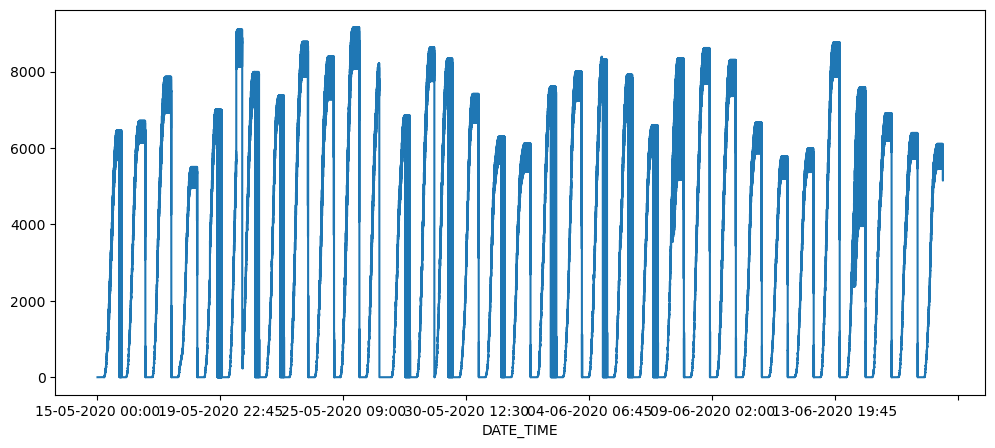

In [4]:
df1['DAILY_YIELD'].plot(figsize=(12,5))

In [5]:
adf_test(df1['DAILY_YIELD'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.087451e+00
p-value                 4.499921e-10
# lags used             6.200000e+01
# observations          6.871500e+04
critical value (1%)    -3.430445e+00
critical value (5%)    -2.861582e+00
critical value (10%)   -2.566792e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is Stationary


In [6]:
# Get number of lines of last week

def get_last_week(df):
    # Guarantee DATE_TIME is a proper datetime index
    df.index = pd.to_datetime(df.index, format='%d-%m-%Y %H:%M')

    start_date = df.index.max() - pd.Timedelta(days=7)

    last_week_df = df.loc[start_date:]

    len_last_week = len(last_week_df)

    print(f"Number of rows in the last week: {len_last_week}")

    return len_last_week

In [7]:
len_last_week = get_last_week(df1)

Number of rows in the last week: 14762


In [8]:
train = df1.iloc[:-len_last_week:]
test = df1.iloc[-len_last_week:]

In [9]:
df1.index = pd.to_datetime(df1.index, format='%d-%m-%Y %H:%M')

# Resample to averages in minutes
df_min = df1.resample('min').mean()
df_min = df_min.dropna()

In [10]:
model = auto_arima(df_min['DAILY_YIELD'], seasonal=False)

c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(2, 0, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result ei

In [11]:
model.summary()

c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3158
Model:                     ARMA(4, 2)   Log Likelihood              -24735.195
Method:                       css-mle   S.D. of innovations            609.601
Date:                Tue, 19 Aug 2025   AIC                          49486.390
Time:                        14:17:35   BIC                          49534.851
Sample:                             0   HQIC                         49503.776
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3325.9243    111.505     29.828      0.000    3107.379    3544.470
ar.L1.y        3.0085        nan        nan        nan         nan         nan
ar.L2.y       -3.1250        nan        nan        nan         nan         nan
ar.L3.y        1.2196   6.11e-05   1.99e+04      0.000       1.219       1.220
ar.L4.y       -0.1035   4.88e-05  -2121.639      0.000      -0.104      -0.103
ma.L1.y       -1.9673      0.004   -486.609      0.000      -1.975      -1.959
ma.L2.y        0.9713      0.004    239.959      0.000       0.963       0.979
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9989           -0.0659j            1.0010           -0.0105
AR.2            0.9989           +0.0659j            1.0010            0.0105
AR.3            1.1116           -0.0000j            1.1116           -0.0000
AR.4            8.6747           -0.0000j            8.6747           -0.0000
MA.1            1.0127           -0.0625j            1.0147           -0.0098
MA.2            1.0127           +0.0625j            1.0147            0.0098
-----------------------------------------------------------------------------
"""

In [12]:
p, d, q = model.order
print(f"ARIMA order: p={p}, d={d}, q={q}")

ARIMA order: p=4, d=0, q=2


In [13]:
# ARMA
results_arma = ARMA(df1['DAILY_YIELD'], order=(p,d,q)).fit()

c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, wh

In [14]:
results_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            DAILY_YIELD   No. Observations:                68778
Model:                     ARMA(4, 0)   Log Likelihood             -562838.584
Method:                       css-mle   S.D. of innovations            866.488
Date:                Tue, 19 Aug 2025   AIC                        1125689.168
Time:                        14:17:37   BIC                        1125744.000
Sample:                             0   HQIC                       1125706.093
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3295.9687    175.324     18.799      0.000    2952.339    3639.598
ar.L1.DAILY_YIELD     0.2145      0.004     56.273      0.000       0.207       0.222
ar.L2.DAILY_YIELD     0.4185      0.004    115.018      0.000       0.411       0.426
ar.L3.DAILY_YIELD     0.3672      0.004    100.916      0.000       0.360       0.374
ar.L4.DAILY_YIELD    -0.0191      0.004     -5.015      0.000      -0.027      -0.012
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0090           -0.0000j            1.0090           -0.0000
AR.2           -1.0540           -1.2007j            1.5977           -0.3647
AR.3           -1.0540           +1.2007j            1.5977            0.3647
AR.4           20.3073           -0.0000j           20.3073           -0.0000
-----------------------------------------------------------------------------
"""

In [15]:
start = len(train)
end = len(train) + len(test) -1

In [16]:
predictions_arma = results_arma.predict(start, end).rename('ARMA Prediction')

In [17]:
predictions_arma

DATE_TIME
2020-06-10 23:45:00    6420.907616
2020-06-10 23:45:00    6339.419604
2020-06-10 23:45:00    6236.288843
2020-06-10 23:45:00    6274.016794
2020-06-10 23:45:00    6478.287998
                          ...     
2020-06-17 23:45:00    5890.954761
2020-06-17 23:45:00    5877.305322
2020-06-17 23:45:00    5711.911698
2020-06-17 23:45:00    5543.577792
2020-06-17 23:45:00    5521.723812
Name: ARMA Prediction, Length: 14762, dtype: float64

<AxesSubplot:xlabel='DATE_TIME'>

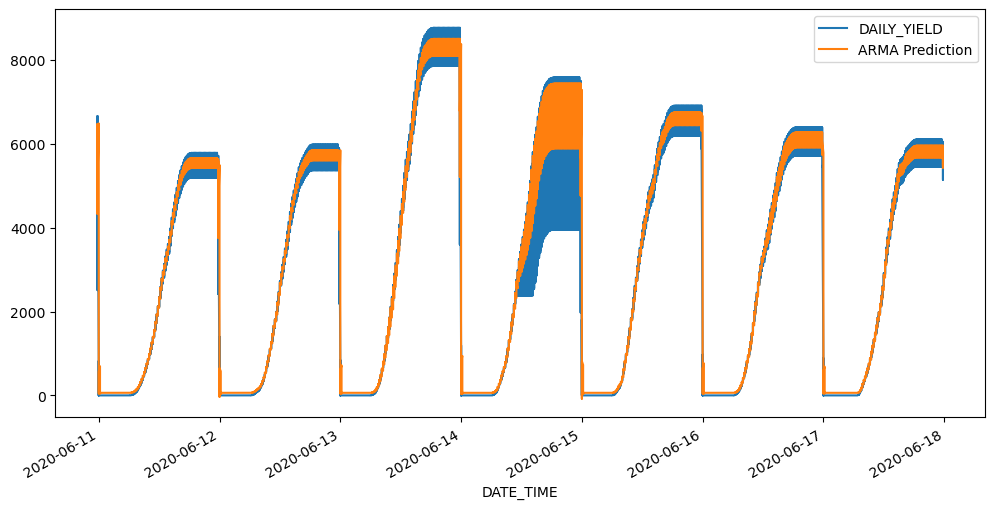

In [18]:
test['DAILY_YIELD'].plot(figsize=(12,6), legend=True)
predictions_arma.plot(legend=True)

In [19]:
test['DAILY_YIELD'].mean()

3200.8839518234954

In [20]:
predictions_arma.mean()

3202.7638545671425

In [21]:
mae_arma = mean_absolute_error(test['DAILY_YIELD'], predictions_arma)
print(f"MAE: {mae_arma}")

MAE: 149.17606149906473


In [22]:
error_arma = (mae_arma / test['DAILY_YIELD'].mean()) * 100
accuracy_arma = 100 - error_arma

print(f'Accuracy (ARMA): {accuracy_arma}%')


Accuracy (ARMA): 95.339535461319%


In [23]:
# ARIMA
results_arima = ARIMA(df1['DAILY_YIELD'], order = (d, q, p)).fit()

c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [24]:
results_arima.summary()

c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D2.DAILY_YIELD   No. Observations:                68776
Model:                 ARIMA(0, 2, 4)   Log Likelihood             -562963.613
Method:                       css-mle   S.D. of innovations            868.196
Date:                Tue, 19 Aug 2025   AIC                        1125939.227
Time:                        14:17:59   BIC                        1125994.058
Sample:                             2   HQIC                       1125956.152
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9.906e-07   3.62e-05     -0.027      0.978    -7.2e-05       7e-05
ma.L1.D2.DAILY_YIELD    -1.8554   4.42e-07  -4.19e+06      0.000      -1.855      -1.855
ma.L2.D2.DAILY_YIELD     1.0878        nan        nan        nan         nan         nan
ma.L3.D2.DAILY_YIELD    -0.3923        nan        nan        nan         nan         nan
ma.L4.D2.DAILY_YIELD     0.1598        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            1.2321           -0.0000j            1.2321           -0.0000
MA.3            0.1111           -2.2507j            2.2534           -0.2422
MA.4            0.1111           +2.2507j            2.2534            0.2422
-----------------------------------------------------------------------------
"""

In [25]:
predictions_arima = results_arima.predict(start=start, end=end, typ='levels').rename('ARIMA Prediction')

In [26]:
predictions_arima

DATE_TIME
2020-06-10 23:45:00    6491.896628
2020-06-10 23:45:00    6426.896036
2020-06-10 23:45:00    6299.174632
2020-06-10 23:45:00    6468.163643
2020-06-10 23:45:00    6483.855252
                          ...     
2020-06-17 23:45:00    5866.057351
2020-06-17 23:45:00    5867.747672
2020-06-17 23:45:00    5780.707896
2020-06-17 23:45:00    5602.774637
2020-06-17 23:45:00    5757.808595
Name: ARIMA Prediction, Length: 14762, dtype: float64

<AxesSubplot:xlabel='DATE_TIME'>

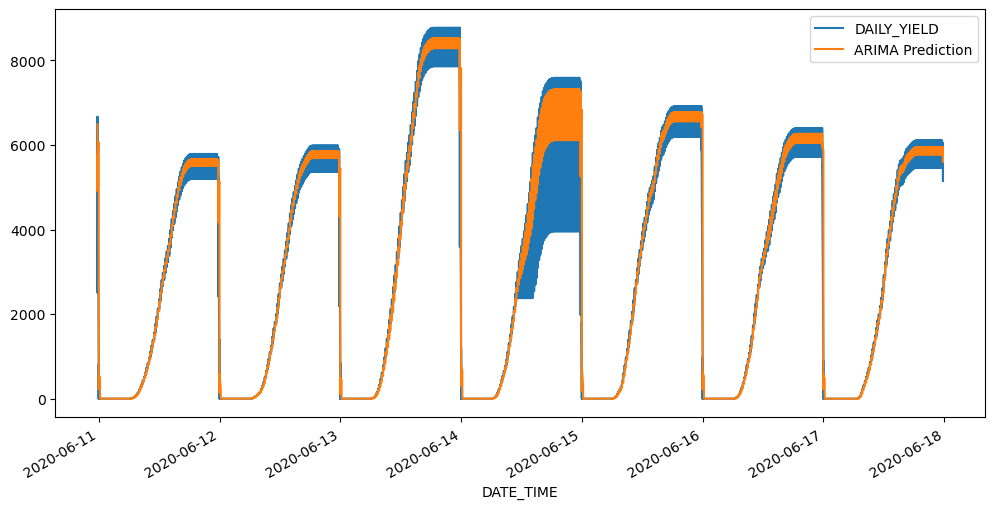

In [27]:
test['DAILY_YIELD'].plot(figsize=(12,6), legend=True)
predictions_arima.plot(legend=True)

In [28]:
test['DAILY_YIELD'].mean()

3200.8839518234954

In [29]:
predictions_arma.mean()

3202.7638545671425

In [30]:
mae_arima = mean_absolute_error(test['DAILY_YIELD'], predictions_arima)
print(f"MAE: {mae_arima}")

MAE: 118.30936334780908


In [31]:
error_arima = (mae_arima / test['DAILY_YIELD'].mean()) * 100
accuracy_arima = 100 - error_arima

print(f'Accuracy (ARIMA): {accuracy_arima}%')


Accuracy (ARIMA): 96.30385340023308%


<AxesSubplot:xlabel='DATE_TIME'>

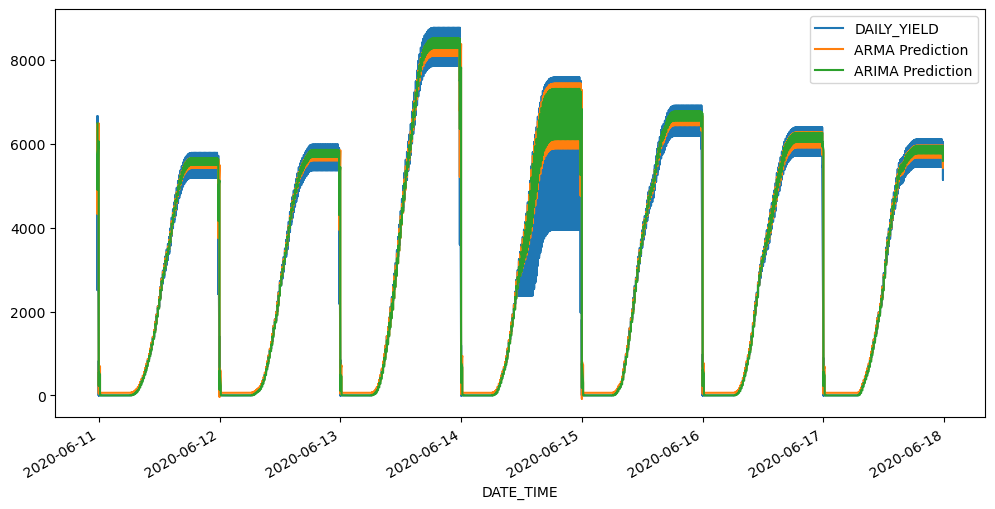

In [32]:
test['DAILY_YIELD'].plot(figsize=(12,6), legend=True)
predictions_arma.plot(legend=True)
predictions_arima.plot(legend=True)

In [33]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

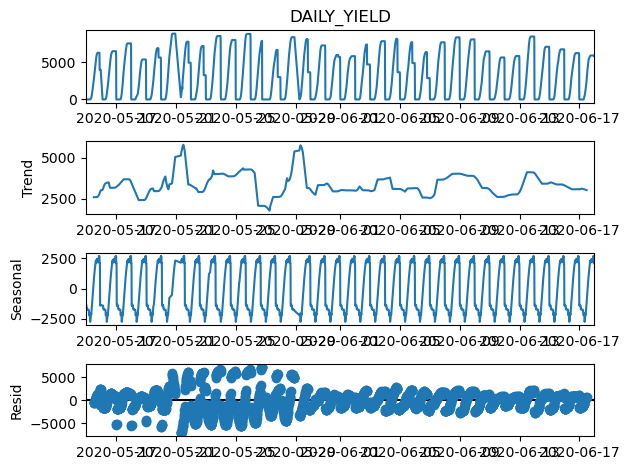

In [34]:
results = seasonal_decompose(df_min['DAILY_YIELD'], model='add', period=96)
results.plot();

<AxesSubplot:xlabel='DATE_TIME'>

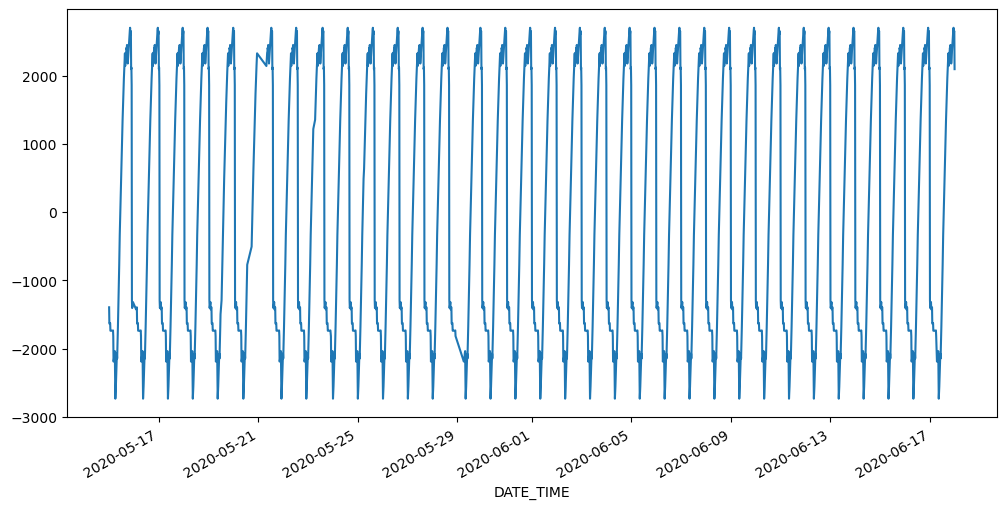

In [35]:
results.seasonal.plot(figsize=(12,6))

In [41]:
model = auto_arima(df_min['DAILY_YIELD'], seasonal=True, m=96)

c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Utilizador\miniconda3\envs\tsa_course\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3158
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood              -24690.099
Date:                                 Tue, 19 Aug 2025   AIC                          49396.197
Time:                                         14:23:15   BIC                          49444.659
Sample:                                              0   HQIC                         49413.583
                                                - 3158                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     84.5945     25.697      3.292      0.001      34.230     134.959
ar.L1          0.9544      0.009    102.012      0.000       0.936       0.973
ma.L1          0.1110      0.025      4.485      0.000       0.062       0.159
ar.S.L12       1.4062      0.006    241.050      0.000       1.395       1.418
ar.S.L24      -0.9858      0.003   -345.283      0.000      -0.991      -0.980
ma.S.L12      -1.3741      0.013   -102.217      0.000      -1.400      -1.348
ma.S.L24       0.9282      0.007    124.392      0.000       0.914       0.943
sigma2      4.013e+05   4945.597     81.135      0.000    3.92e+05    4.11e+05
===================================================================================
Ljung-Box (Q):                       82.27   Jarque-Bera (JB):            962773.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -8.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        86.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

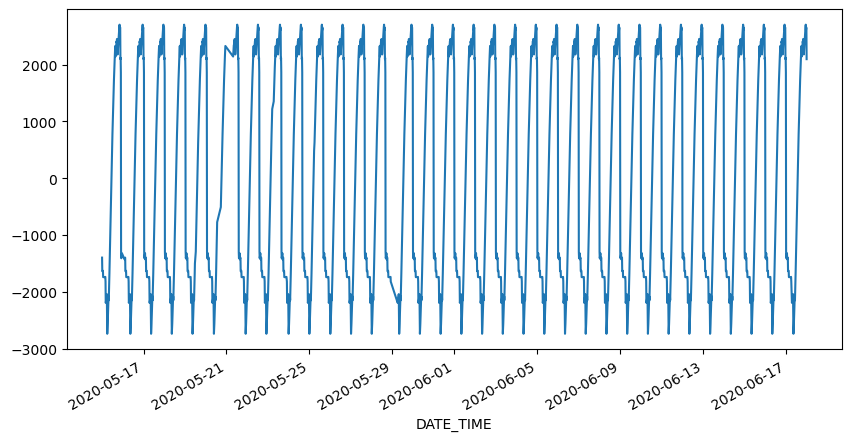

In [38]:
results = seasonal_decompose(df_min['DAILY_YIELD'], model='add', period=96)
results.seasonal.plot(figsize=(10,5));

In [39]:
len(df_min)

3158